In [1]:
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.naive_bayes import GaussianNB

pd.set_option('display.height', 1000)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
%matplotlib inline
sns.set(style='whitegrid',context='notebook')

height has been deprecated.



In [2]:
far_df = pd.read_csv('./firmannualreports.csv',index_col=0)
ptu_df = pd.read_csv('./processtechnologyuses.csv',index_col=0)
results_df = pd.read_csv('./firmanalyticsresults.csv',index_col=0)

In [3]:
df = far_df.merge(results_df,how='inner',left_on='firmanalyticsresultid',right_index=True)
df = df.merge(ptu_df.astype('int'),how='inner',left_on='processtechnologyuseid',right_index=True)
df.head()

,year,yearsinbusiness,firmid,firmsectionid,clientid,revenueid,processid,processtechnologyuseid,financialsid,firmanalyticsresultid,Year,CashflowValue,NetBalanceSheet,TotalValue,NetRevenue,OperatingExpenses,IncomeFromOperations,Ebitda,Eboc,TruelyticsScore,DiscountRate,ComparablesId,GrowthRateId,ExpenseRatioId,DiscountFactorId,BusinessStabilityId,MarketStabilityId,ClientStabilityId,ProFormaId,crm,accounting,portfoliomanagement,portfolioaccounting,financialplanning,firmwebsite,clientportal,socialmedia,email,digitalcompliancemonitoring,digitalfinancialrecords,robotechnology,riskassessmentsoftware
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2014,28.0,591,1,1,1,1,1,1,1,2014,7.208358e+06,0.0,7.208358e+06,2350000.0,557000.0,1793000.0,1830000.0,2360000.0,2.944333,30.3,1,1,1,1,1,3,2,1,1,1,1,1,1,1,1,1,1,1,1,0,0
2,2014,18.0,592,2,2,2,2,2,2,2,2014,3.905339e+06,0.0,3.905339e+06,1320000.0,752933.0,567067.0,567067.0,692900.0,2.388833,31.9,2,2,2,2,4,6,5,2,1,1,1,1,1,1,1,1,1,0,1,0,0
4,2014,17.0,203,4,4,4,4,4,4,4,2014,1.549818e+06,0.0,1.549818e+06,662674.0,392050.0,270624.0,294924.0,473224.0,2.388667,33.2,4,4,4,4,10,12,11,4,0,0,1,1,0,0,0,0,0,1,1,0,0
5,2015,18.0,203,5,5,5,5,5,5,5,2015,1.376342e+06,0.0,1.376342e+06,662674.0,392050.0,270624.0,294924.0,473224.0,2.388667,32.5,5,5,5,5,13,15,14,5,0,0,1,1,0,0,0,0,0,1,1,0,0
6,2016,19.0,203,6,6,6,6,6,6,6,2016,3.986275e+06,0.0,3.986275e+06,1443750.0,511050.0,932700.0,957000.0,1207000.0,3.055500,28.9,6,6,6,6,16,18,17,6,1,1,1,1,1,0,1,1,0,1,1,0,1


In [78]:
fts = ['crm', 'accounting', 'portfoliomanagement', 
        'portfolioaccounting', 'financialplanning', 
        'firmwebsite', 'clientportal', 'socialmedia',
        'email', 'digitalcompliancemonitoring', 'digitalfinancialrecords', 
        'robotechnology', 'riskassessmentsoftware','NetRevenue','OperatingExpenses',
        'Ebitda','Eboc']
tech_fts = ptu_df.columns
maxTech = ptu_df.columns.shape[0]
df1 = df[fts].copy()

In [79]:
rev25,rev50,rev75 = df1['NetRevenue'].describe()[4:7]
opex25,opex50,opex75 = df1['OperatingExpenses'].describe()[4:7]
ebitda25,ebitda50,ebitda75 = df1['Ebitda'].describe()[4:7]
eboc25,eboc50,eboc75 = df1['Eboc'].describe()[4:7]

print 'net revenue 25,50,75: ',rev25,rev50,rev75
print 'operating expenses 25,50,75: ',opex25,opex50,opex75
print 'ebitda 25,50,75: ',ebitda25,ebitda50,ebitda75
print 'eboc 25,50,75: ',eboc25,eboc50,eboc75

#create features for ranges below 25%, 25-50%, 50-75%, and above 75%
df1['NetRevenue(<=25)'] = (df1['NetRevenue'] <= rev25).astype('int')
df1['NetRevenue(26-50)'] = ((df1['NetRevenue'] > rev25) & (df1['NetRevenue'] <= rev50)).astype('int')
df1['NetRevenue(51-75)'] = ((df1['NetRevenue'] > rev50) & (df1['NetRevenue'] <= rev75)).astype('int')
df1['NetRevenue(>75)'] = (df1['NetRevenue'] > rev75).astype('int')

df1['OpExpenses(<=25)'] = (df1['OperatingExpenses'] <= opex25).astype('int')
df1['OpExpenses(26-50)'] = ((df1['OperatingExpenses'] > opex25) & (df1['OperatingExpenses'] <= opex50)).astype('int')
df1['OpExpenses(51-75)'] = ((df1['OperatingExpenses'] > opex50) & (df1['OperatingExpenses'] <= opex75)).astype('int')
df1['OpExpenses(>75)'] = (df1['OperatingExpenses'] > opex75).astype('int')

df1['Ebitda(<=25)'] = (df1['Ebitda'] <= ebitda25).astype('int')
df1['Ebitda(26-50)'] = ((df1['Ebitda'] > ebitda25) & (df1['Ebitda'] <= ebitda50)).astype('int')
df1['Ebitda(51-75)'] = ((df1['Ebitda'] > ebitda50) & (df1['Ebitda'] <= ebitda75)).astype('int')
df1['Ebitda(>75)'] = (df1['Ebitda'] > ebitda75).astype('int')

df1['Eboc(<=25)'] = (df1['Eboc'] <= eboc25).astype('int')
df1['Eboc(26-50)'] = ((df1['Eboc'] > eboc25) & (df1['Eboc'] <= eboc50)).astype('int')
df1['Eboc(51-75)'] = ((df1['Eboc'] > eboc50) & (df1['Eboc'] <= eboc75)).astype('int')
df1['Eboc(>75)'] = (df1['Eboc'] > eboc75).astype('int')

net revenue 25,50,75:  413112.25 815967.665 1668845.0
operating expenses 25,50,75:  93249.25 356870.0 845895.5
ebitda 25,50,75:  159426.75 371734.78 806292.0
eboc 25,50,75:  285750.0 566872.0 1131605.25


In [80]:
df1.head()

,crm,accounting,portfoliomanagement,portfolioaccounting,financialplanning,firmwebsite,clientportal,socialmedia,email,digitalcompliancemonitoring,digitalfinancialrecords,robotechnology,riskassessmentsoftware,NetRevenue,OperatingExpenses,Ebitda,Eboc,NetRevenue(<=25),NetRevenue(26-50),NetRevenue(51-75),NetRevenue(>75),OpExpenses(<=25),OpExpenses(26-50),OpExpenses(51-75),OpExpenses(>75),Ebitda(<=25),Ebitda(26-50),Ebitda(51-75),Ebitda(>75),Eboc(<=25),Eboc(26-50),Eboc(51-75),Eboc(>75)
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1,1,1,1,1,1,1,1,1,1,1,0,0,2350000.0,557000.0,1830000.0,2360000.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1
2,1,1,1,1,1,1,1,1,1,0,1,0,0,1320000.0,752933.0,567067.0,692900.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0
4,0,0,1,1,0,0,0,0,0,1,1,0,0,662674.0,392050.0,294924.0,473224.0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
5,0,0,1,1,0,0,0,0,0,1,1,0,0,662674.0,392050.0,294924.0,473224.0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0
6,1,1,1,1,1,0,1,1,0,1,1,0,1,1443750.0,511050.0,957000.0,1207000.0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1


In [65]:
#For conditional probability P(A|B)
def findConditionalProbability(df,num_fts,col):
    A = [df.loc[((df[tech_fts]==1).sum(axis=1)==x) & (df[col]==1)].shape[0] for x in np.arange(num_fts+1)]
    B = [df.loc[(df[tech_fts]==1).sum(axis=1)==x].shape[0] for x in np.arange(num_fts+1)]
    proba = [ai/(bi*1.0) for ai,bi in zip(A,B)]
    descrip = [('P(%s|%d tech)' % (col,x)) for x in np.arange(num_fts+1)]
    return proba

In [81]:
n_tech = list(np.arange(maxTech+1))
pRev1 = findConditionalProbability(df1,maxTech,'NetRevenue(<=25)')
pRev2 = findConditionalProbability(df1,maxTech,'NetRevenue(26-50)')
pRev3 = findConditionalProbability(df1,maxTech,'NetRevenue(51-75)')
pRev4 = findConditionalProbability(df1,maxTech,'NetRevenue(>75)')

cols = ['N_Technology','P(NetRevenue(<=25)|N)','P(NetRevenue(26-50)|N)','P(NetRevenue(51-75)|N)','P(NetRevenue(>75)|N)']
df2 = pd.DataFrame(zip(n_tech,pRev1,pRev2,pRev3,pRev4),columns=cols)
df2
#What types of technology are more important?

,N_Technology,P(NetRevenue(<=25)|N),P(NetRevenue(26-50)|N),P(NetRevenue(51-75)|N),P(NetRevenue(>75)|N)
0,0,0.807692,0.134615,0.038462,0.019231
1,1,0.500000,0.200000,0.200000,0.100000
2,2,0.250000,0.333333,0.250000,0.166667
3,3,0.375000,0.250000,0.250000,0.125000
4,4,0.300000,0.400000,0.150000,0.150000
5,5,0.555556,0.111111,0.222222,0.111111
6,6,0.238095,0.404762,0.190476,0.166667
7,7,0.261538,0.230769,0.323077,0.184615
8,8,0.136986,0.328767,0.178082,0.356164
9,9,0.231481,0.231481,0.287037,0.250000


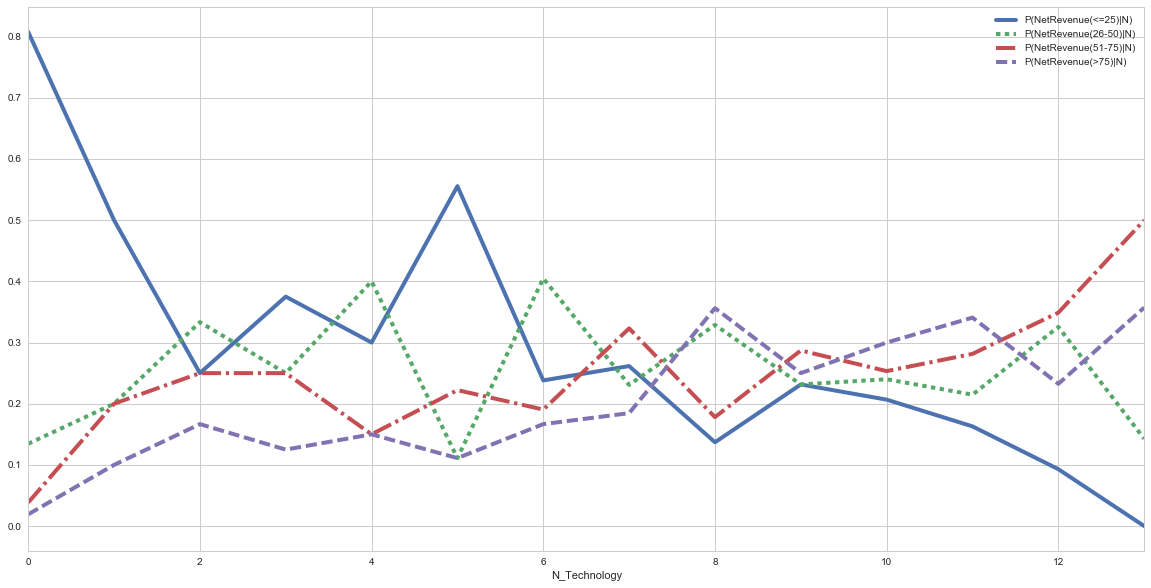

In [109]:
style = ['-',':','-.','--']
df2.plot(x='N_Technology',y=df2.columns[1:],style=style,linewidth=4,figsize=(20,10))

In [82]:
n_tech = list(np.arange(maxTech+1))
pOpEx1 = findConditionalProbability(df1,maxTech,'OpExpenses(<=25)')
pOpEx2 = findConditionalProbability(df1,maxTech,'OpExpenses(26-50)')
pOpEx3 = findConditionalProbability(df1,maxTech,'OpExpenses(51-75)')
pOpEx4 = findConditionalProbability(df1,maxTech,'OpExpenses(>75)')

cols = ['N_Technology','P(OpExpenses(<=25)|N)','P(OpExpenses(26-50)|N)','P(OpExpenses(51-75)|N)','P(OpExpenses(>75)|N)']
df3 = pd.DataFrame(zip(n_tech,pOpEx1,pOpEx2,pOpEx3,pOpEx4),columns=cols)
df3

,N_Technology,P(OpExpenses(<=25)|N),P(OpExpenses(26-50)|N),P(OpExpenses(51-75)|N),P(OpExpenses(>75)|N)
0,0,0.769231,0.153846,0.057692,0.019231
1,1,0.500000,0.200000,0.200000,0.100000
2,2,0.333333,0.250000,0.250000,0.166667
3,3,0.375000,0.125000,0.375000,0.125000
4,4,0.150000,0.450000,0.250000,0.150000
5,5,0.333333,0.444444,0.111111,0.111111
6,6,0.214286,0.309524,0.333333,0.142857
7,7,0.153846,0.415385,0.261538,0.169231
8,8,0.232877,0.219178,0.260274,0.287671
9,9,0.277778,0.185185,0.250000,0.287037


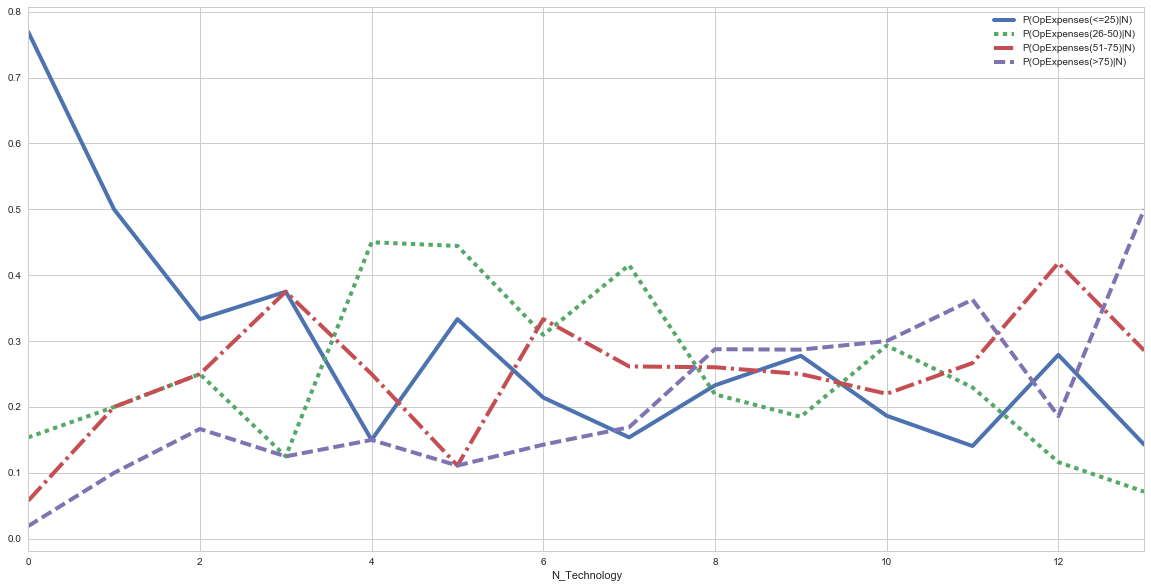

In [110]:
style = ['-',':','-.','--']
df3.plot(x='N_Technology',y=df3.columns[1:],style=style,linewidth=4,figsize=(20,10))

In [85]:
n_tech = list(np.arange(maxTech+1))
pEbitda1 = findConditionalProbability(df1,maxTech,'Ebitda(<=25)')
pEbitda2 = findConditionalProbability(df1,maxTech,'Ebitda(26-50)')
pEbitda3 = findConditionalProbability(df1,maxTech,'Ebitda(51-75)')
pEbitda4 = findConditionalProbability(df1,maxTech,'Ebitda(>75)')

cols = ['N_Technology','P(Ebitda(<=25)|N)','P(Ebitda(26-50)|N)','P(Ebitda(51-75)|N)','P(Ebitda(>75)|N)']
df4 = pd.DataFrame(zip(n_tech,pEbitda1,pEbitda2,pEbitda3,pEbitda4),columns=cols)
df4

,N_Technology,P(Ebitda(<=25)|N),P(Ebitda(26-50)|N),P(Ebitda(51-75)|N),P(Ebitda(>75)|N)
0,0,0.692308,0.230769,0.057692,0.019231
1,1,0.500000,0.100000,0.300000,0.100000
2,2,0.250000,0.250000,0.333333,0.166667
3,3,0.250000,0.375000,0.250000,0.125000
4,4,0.300000,0.350000,0.200000,0.150000
5,5,0.444444,0.166667,0.111111,0.277778
6,6,0.285714,0.214286,0.309524,0.190476
7,7,0.323077,0.215385,0.215385,0.246154
8,8,0.178082,0.232877,0.246575,0.342466
9,9,0.194444,0.268519,0.296296,0.240741


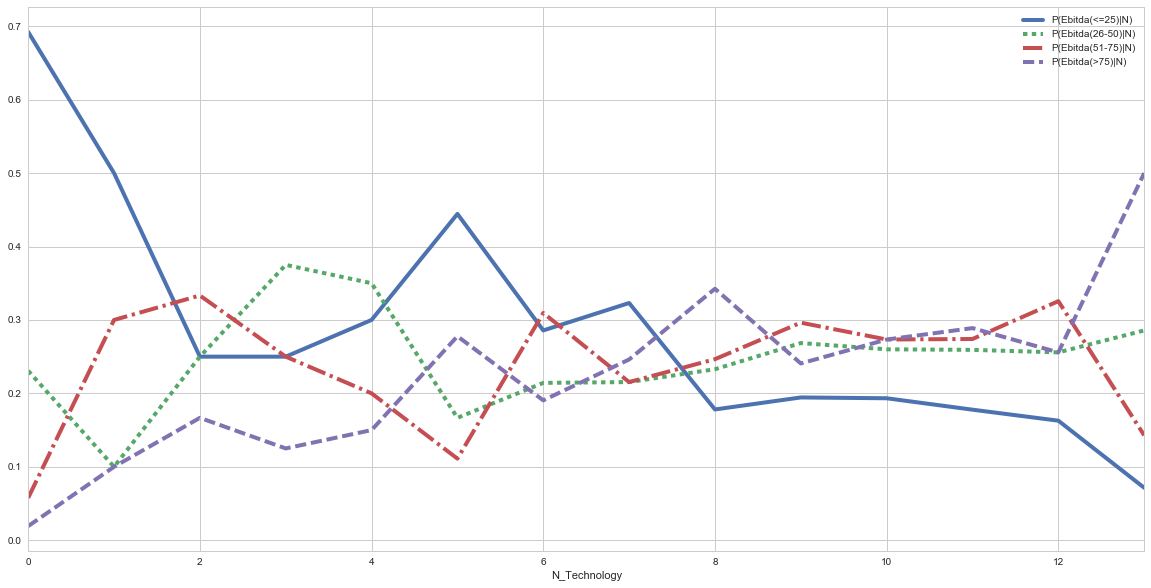

In [111]:
style = ['-',':','-.','--']
df4.plot(x='N_Technology',y=df4.columns[1:],style=style,linewidth=4,figsize=(20,10))

In [86]:
n_tech = list(np.arange(maxTech+1))
pEboc1 = findConditionalProbability(df1,maxTech,'Eboc(<=25)')
pEboc2 = findConditionalProbability(df1,maxTech,'Eboc(26-50)')
pEboc3 = findConditionalProbability(df1,maxTech,'Eboc(51-75)')
pEboc4 = findConditionalProbability(df1,maxTech,'Eboc(>75)')

cols = ['N_Technology','P(Eboc(<=25)|N)','P(Eboc(26-50)|N)','P(Eboc(51-75)|N)','P(Eboc(>75)|N)']
df5 = pd.DataFrame(zip(n_tech,pEboc1,pEboc2,pEboc3,pEboc4),columns=cols)
df5

,N_Technology,P(Eboc(<=25)|N),P(Eboc(26-50)|N),P(Eboc(51-75)|N),P(Eboc(>75)|N)
0,0,0.788462,0.153846,0.038462,0.019231
1,1,0.600000,0.100000,0.200000,0.100000
2,2,0.166667,0.333333,0.250000,0.250000
3,3,0.375000,0.250000,0.250000,0.125000
4,4,0.300000,0.350000,0.200000,0.150000
5,5,0.500000,0.166667,0.222222,0.111111
6,6,0.261905,0.380952,0.190476,0.166667
7,7,0.230769,0.246154,0.261538,0.261538
8,8,0.150685,0.246575,0.273973,0.328767
9,9,0.231481,0.185185,0.305556,0.277778


In [ ]:
style = ['-',':','-.','--']
df2.plot(x='N_Technology',y=df2.columns[1:],style=style,linewidth=4,figsize=(20,10))